In [6]:
from model import *


In [7]:
# load data
frames=md.load_xtc("./singlesim/it50k/eql2.xtc",top="./singlesim/it50k/conf.gro")

In [8]:
# showing the molecule
molecule = frames[0]
atomic_numbers = [atom.element.atomic_number for atom in molecule.top.atoms]
water = Atoms(positions=molecule.xyz[0], numbers=atomic_numbers)
show_ase(water)



NGLWidget()

In [9]:
def rotate3D(features,psi,theta,phi):
    xyz = features[:,:3]
    rest = features[:,3:]
    matrix = np.array([[np.cos(psi)*np.cos(phi)-np.cos(theta)*np.sin(phi)*np.sin(psi),np.cos(psi)*np.sin(phi)+np.cos(theta)*np.cos(phi)*np.sin(psi),np.sin(psi)*np.sin(theta)],
                          [-np.sin(psi)*np.cos(phi)-np.cos(theta)*np.sin(phi)*np.cos(psi),-np.sin(psi)*np.sin(phi)+np.cos(theta)*np.cos(phi)*np.cos(psi),np.cos(psi)*np.sin(theta)],
                            [np.sin(theta)*np.sin(phi),-np.sin(theta)*np.cos(phi),np.cos(theta)]])
    return np.concatenate((np.dot(xyz,matrix) *10 , rest),axis=1) 

In [10]:
features=[]
for molecule in tqdm(frames):
    atomic_numbers = np.array([[atom.element.atomic_number for atom in molecule.top.atoms]]).T
    vdwr = np.array([[atom.element.radius for atom in molecule.top.atoms]]).T
    mass = np.array([[atom.element.mass for atom in molecule.top.atoms]]).T
    positions = molecule.xyz[0]
    # positions = molecule.xyz[0]*10
    
    positions = positions - positions[0]
    
    node_features = np.concatenate((positions,vdwr,atomic_numbers),axis=1)
    features.append(node_features)
    
features = np.array(features)

100%|██████████| 50001/50001 [00:01<00:00, 45719.38it/s]


In [11]:
print("Node Features:\n",features[50000])
# positions , vdwr , atomic_numbers 

Node Features:
 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.52000000e-01
   8.00000000e+00]
 [ 9.28936005e-02 -2.27902532e-02  3.70174646e-03  1.20000000e-01
   1.00000000e+00]
 [-4.31962013e-02 -8.00951123e-02 -2.96847820e-02  1.20000000e-01
   1.00000000e+00]
 [ 5.30153513e-03 -1.09754801e-02 -2.77179480e-03  0.00000000e+00
   0.00000000e+00]]


In [12]:
# create edge list
from_list = []

to_list = []
for edge in frames.topology.bonds:
    from_list.append(edge.atom1.index)
    to_list.append(edge.atom2.index)
    from_list.append(edge.atom2.index)
    to_list.append(edge.atom1.index)

edge_list = np.array([from_list,to_list])

In [13]:
edge_list

array([[0, 1, 0, 2],
       [1, 0, 2, 0]])

In [14]:
def convert_to_adj(edge_index, num_nodes=None):
    if num_nodes is None:
        num_nodes = edge_index.max() + 1
    adj = torch.zeros(num_nodes, num_nodes)
    adj[edge_index[0], edge_index[1]] = 1
    return adj

def convert_to_edge_index(adj):
    edge_index = adj.nonzero().t()
    return edge_index

In [15]:
graphs = []


In [16]:
for node_feature in tqdm(features):
    graph = data.Data(x=torch.from_numpy(node_feature),edge_index=torch.from_numpy(edge_list))
    graphs.append(graph)
    

100%|██████████| 50001/50001 [00:00<00:00, 70402.17it/s]


In [17]:
print(graphs[0])
# 4 atoms with 5 features each and 4 edges with 2 features each

Data(x=[4, 5], edge_index=[2, 4])


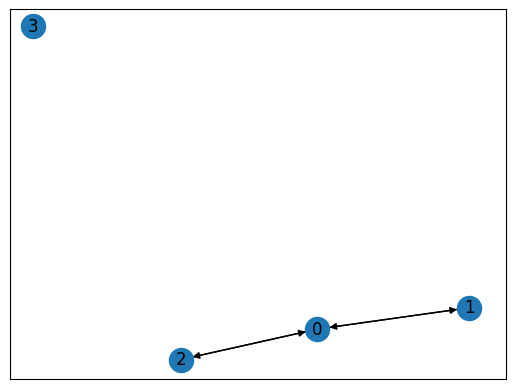

In [18]:
vis = to_networkx(graphs[0])
nx.draw_networkx(vis, with_labels=True)


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
graphs_device = []
for graph in tqdm(graphs):
    graphs_device.append(graph.to(device))

100%|██████████| 50001/50001 [00:00<00:00, 193657.45it/s]


In [20]:
import os
in_channels = graph.num_features
out_channels = 3
n_atoms = 4
lr = 1e-3
n_epochs = 20
batch_size=256
test_train_split = 0.8
model_name = "IntraGVAE_l3_final.pt"
model_loaded = False
force_train = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if os.path.exists("./models/"+model_name) and not force_train:
    model = torch.load("./models/"+model_name)
    model_loaded = True
else:
    model = VGAE(VariationalGCNEncoder(in_channels, out_channels,batch_size,n_atoms),
                VariationalGCNDecoder(out_channels, in_channels,batch_size,n_atoms))
    
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

In [21]:
split = int(test_train_split * len(graphs_device))
train_loader = DataLoader(graphs_device[:split], batch_size=batch_size,shuffle=True)
test_loader = DataLoader(graphs_device[split:], batch_size=batch_size,shuffle=True)

In [22]:
print("Using:",device )
print("total_graphs:", len(graphs_device))
print("Graphs in a batch:", batch_size)
print("Train Graphs Batches:",len(train_loader),f"(Total graphs: {len(train_loader)*batch_size})")
print("Test Graphs Batches:",len(test_loader),f"(Total graphs: {len(test_loader)*batch_size})")
print("Model Specifics:\n",model)

Using: cpu
total_graphs: 50001
Graphs in a batch: 256
Train Graphs Batches: 157 (Total graphs: 40192)
Test Graphs Batches: 40 (Total graphs: 10240)
Model Specifics:
 VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GATConv(5, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(16, 3, bias=True)
    (mu): Linear(3, 3, bias=True)
    (logstd): Linear(3, 3, bias=True)
  )
  (decoder): VariationalGCNDecoder(
    (inv_transform): Linear(3, 4, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 5, bias=True)
  )
)


In [23]:
lossFxn = torch.nn.MSELoss()
def train():
    model.train()
    model.double()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    position_loss_all = 0

    for data in train_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        
        heavy_indices = torch.where(data.x[:,4] > torch.tensor([1]).to(device))
     
        
        decoded_pos = decoded_x[:,:3]
        decoded_features = decoded_x[:,3:]
        orignal_pos = data.x[:,:3]
        orignal_features = data.x[:,3:]


        positionLoss = lossFxn(decoded_pos[heavy_indices], orignal_pos[heavy_indices])
        FeatureLoss = lossFxn(decoded_features[heavy_indices], orignal_features[heavy_indices])
        loss = lossFxn(decoded_x[heavy_indices], data.x[heavy_indices])
        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)


        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        position_loss_all += float(positionLoss)

#         positionLoss.backward()
        loss.backward()
        optimizer.step()

    return loss_all / len(train_loader), feature_loss_all / len(train_loader), edge_loss_all / len(train_loader) ,position_loss_all / len(train_loader)

In [24]:
lossFxn = torch.nn.MSELoss()
def test():
    model.eval()
    model.double()
    
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    position_loss_all = 0

    for data in test_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)

        decoded_pos = decoded_x[:,:3]
        decoded_features = decoded_x[:,3:]
        orignal_pos = data.x[:,:3]
        orignal_features = data.x[:,3:]
        
        
        heavy_indices = torch.where(data.x[:,4] > torch.tensor([1]).to(device))
   
        
        positionLoss = lossFxn(decoded_pos[heavy_indices], orignal_pos[heavy_indices])
        FeatureLoss = lossFxn(decoded_features[heavy_indices], orignal_features[heavy_indices])
        loss = lossFxn(decoded_x[heavy_indices], data.x[heavy_indices])

        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        
        
        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        position_loss_all += float(positionLoss)



    return loss_all / len(test_loader), feature_loss_all / len(test_loader), edge_loss_all / len(test_loader), position_loss_all / len(test_loader)

In [25]:
train_total_losses = []
train_feature_losses = []
train_edge_losses = []
train_position_losses = []

test_total_losses = []
test_feature_losses = []
test_edge_losses = []
test_position_losses = []

early_stopper = EarlyStopper(patience=3, min_delta=10)


if model_loaded:        
    print("Pretrained Model Loaded, no training required")
else:
    for epoch in range(1, n_epochs + 1):
        train_total_loss, train_feature_loss, train_edge_loss,train_position_loss = train()
        test_total_loss, test_feature_loss, test_edge_loss,test_position_loss = test()
        
        print(f"Epoch: {epoch:03d}")
        print(f'\tTrain:\tTotal Loss: {train_total_loss:.4f}, Feature Loss: {train_feature_loss:.4f}, Position Loss: {train_position_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')
        print(f'\tTest: \tTotal Loss: {test_total_loss:.4f}, Feature Loss: {test_feature_loss:.4f}, Position Loss: {test_position_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')
        
        if(early_stopper.early_stop(test_total_loss)):
            print("Early Stopping")
            break

        train_total_losses.append(train_total_loss)
        train_feature_losses.append(train_feature_loss)
        train_edge_losses.append(train_edge_loss)
        train_position_losses.append(train_position_loss)

        test_total_losses.append(test_total_loss)
        test_feature_losses.append(test_feature_loss)
        test_edge_losses.append(test_edge_loss)
        test_position_losses.append(test_position_loss)
        
        scheduler.step()

    torch.save(model,"./models/"+model_name)

Epoch: 001
	Train:	Total Loss: 0.9817, Feature Loss: 2.4510, Position Loss: 0.0022, LR: 0.001000
	Test: 	Total Loss: 0.0001, Feature Loss: 0.0001, Position Loss: 0.0001, LR: 0.001000
Epoch: 002
	Train:	Total Loss: 0.0002, Feature Loss: 0.0003, Position Loss: 0.0001, LR: 0.001000
	Test: 	Total Loss: 0.0000, Feature Loss: 0.0000, Position Loss: 0.0001, LR: 0.001000
Epoch: 003
	Train:	Total Loss: 0.0001, Feature Loss: 0.0001, Position Loss: 0.0000, LR: 0.001000
	Test: 	Total Loss: 0.0000, Feature Loss: 0.0000, Position Loss: 0.0000, LR: 0.001000
Epoch: 004
	Train:	Total Loss: 0.0000, Feature Loss: 0.0001, Position Loss: 0.0000, LR: 0.001000
	Test: 	Total Loss: 0.0000, Feature Loss: 0.0000, Position Loss: 0.0000, LR: 0.001000
Epoch: 005
	Train:	Total Loss: 0.0000, Feature Loss: 0.0000, Position Loss: 0.0000, LR: 0.001000
	Test: 	Total Loss: 0.0000, Feature Loss: 0.0000, Position Loss: 0.0000, LR: 0.001000
Epoch: 006
	Train:	Total Loss: 0.0000, Feature Loss: 0.0000, Position Loss: 0.0000, L

In [26]:
model.double()
z,encoded_edge_index = model.encode(graph.x, graph.edge_index)
r,decoded_edge_index = model.decode(z, encoded_edge_index)
decoded_edge_index = graph.edge_index
print("Input Graph features: \n", graph.x)
print("\nInput Edge Index: \n", graph.edge_index)
print("\nEncoded Graph: \n", z)
print("\nDecoded Node features: \n", r)
print("\nDecoded Edge Index: \n", decoded_edge_index)

Input Graph features: 
 tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.5200e-01,  8.0000e+00],
        [ 9.2894e-02, -2.2790e-02,  3.7017e-03,  1.2000e-01,  1.0000e+00],
        [-4.3196e-02, -8.0095e-02, -2.9685e-02,  1.2000e-01,  1.0000e+00],
        [ 5.3015e-03, -1.0975e-02, -2.7718e-03,  0.0000e+00,  0.0000e+00]],
       dtype=torch.float64)

Input Edge Index: 
 tensor([[0, 1, 0, 2],
        [1, 0, 2, 0]])

Encoded Graph: 
 tensor([[-2.0646, -2.3340, -0.6323]], dtype=torch.float64,
       grad_fn=<AddmmBackward0>)

Decoded Node features: 
 tensor([[-1.2856e-05, -1.0142e-05, -1.4802e-05,  1.5127e-01,  7.9992e+00],
        [ 5.9494e-03,  5.0981e-03,  5.9739e-03,  1.4936e-01,  7.9788e+00],
        [ 1.6380e-02,  1.3834e-02,  1.8914e-02,  1.4556e-01,  7.9488e+00],
        [ 4.2241e-02,  3.3020e-02,  5.5880e-02,  1.3251e-01,  7.9198e+00]],
       dtype=torch.float64, grad_fn=<LeakyReluBackward0>)

Decoded Edge Index: 
 tensor([[0, 1, 0, 2],
        [1, 0, 2, 0]])


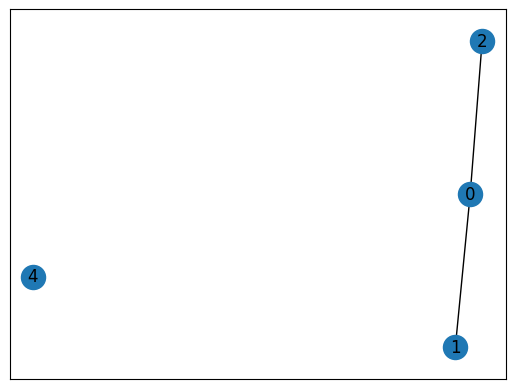

In [27]:
add_self_loops = False
adj_binary = convert_to_adj(decoded_edge_index, r.shape[0])
indices = torch.where(adj_binary)
G = nx.Graph()
if not add_self_loops:
    edges = [(i, j) for i, j in zip(
        indices[0].tolist(), indices[1].tolist()) if i != j]
    G.add_edges_from(edges)
else:
    G.add_edges_from(zip(indices[0].tolist(), indices[1].tolist()))
G.add_node(4)
nx.draw_networkx(G, with_labels=True)
plt.show()


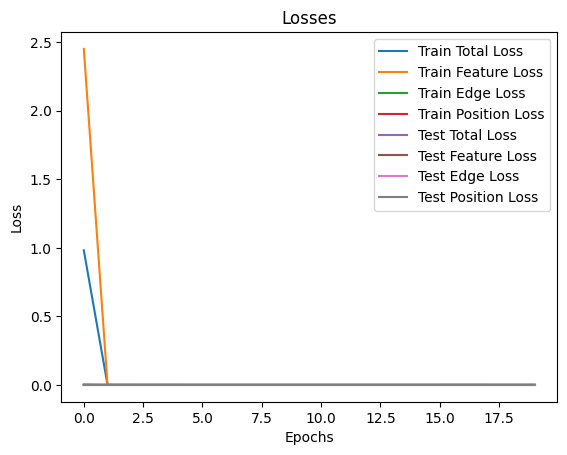

In [28]:
# plotting graphs
plt.plot(train_total_losses, label="Train Total Loss")
plt.plot(train_feature_losses, label="Train Feature Loss")
plt.plot(train_edge_losses, label="Train Edge Loss")
plt.plot(train_position_losses, label="Train Position Loss")
plt.plot(test_total_losses, label="Test Total Loss")
plt.plot(test_feature_losses, label="Test Feature Loss")
plt.plot(test_edge_losses, label="Test Edge Loss")
plt.plot(test_position_losses, label="Test Position Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Losses")
plt.legend()
plt.savefig("losses.png")
plt.show()

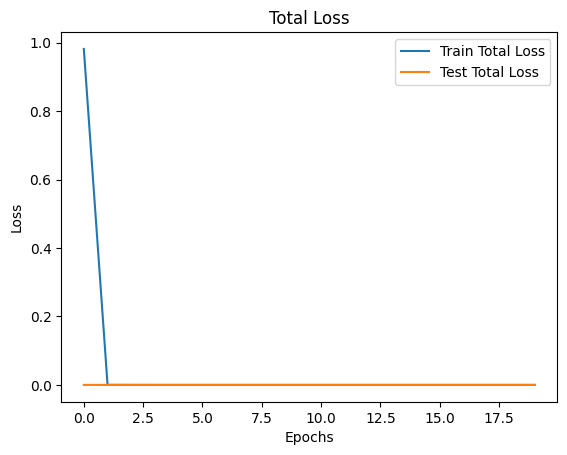

In [29]:
# train vs test total loss
plt.plot(train_total_losses, label="Train Total Loss")
plt.plot(test_total_losses, label="Test Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Total Loss")
plt.legend()
plt.savefig("total_loss.png")
plt.show()


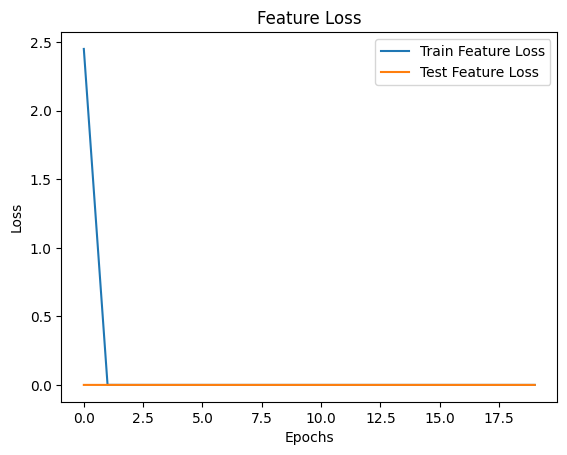

In [30]:
# train vs test feature loss
plt.plot(train_feature_losses, label="Train Feature Loss")
plt.plot(test_feature_losses, label="Test Feature Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Feature Loss")
plt.legend()
plt.savefig("feature_loss.png")
plt.show()


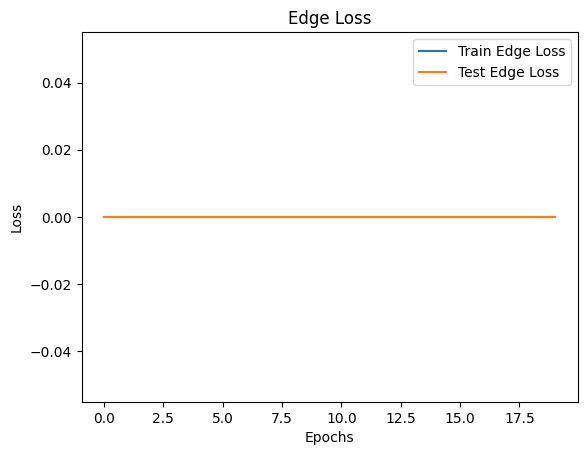

In [31]:
# train vs test edge loss
plt.plot(train_edge_losses, label="Train Edge Loss")
plt.plot(test_edge_losses, label="Test Edge Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Edge Loss")
plt.legend()
plt.savefig("edge_loss.png")
plt.show()


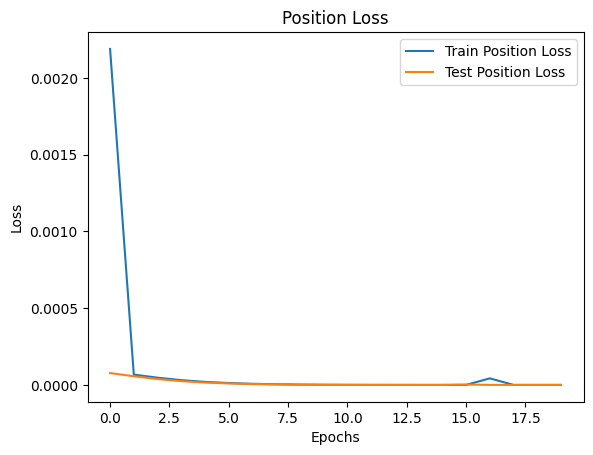

In [32]:
# train vs test position loss
plt.plot(train_position_losses, label="Train Position Loss")
plt.plot(test_position_losses, label="Test Position Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Position Loss")
plt.legend()
plt.savefig("position_loss.png")
plt.show()
